In [1]:
import torch
import pyro
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
import pyro.distributions as dist
# from cosmos.utils.glimpse_reader import CoSMoSDataset

In [3]:
from scipy.io import savemat
plt.rc('text', usetex=True)

In [3]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve

from scipy.io import loadmat

### Orange dye non-attenuated data

Tracker v1.1.3flat

In [4]:
results = {}
predictions = {}
true_labels = {}

names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]

for name in names:
    results[name] = pd.read_csv(
        "/shared/centaur/data/experimental/nonattenuated/{}/runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"
        .format(name),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        "/shared/centaur/data/experimental/nonattenuated/{}/runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/predictions.npy"
        .format(name))
    true_labels[name] = np.load("/shared/centaur/data/experimental/nonattenuated/{}/labels.npy".format(name))

In [5]:
names = ["GraceArticlePol2", "GraceArticleCy5", "LarryCy3sigma54",
         "DanPol2", "DanMed7"]
batch_sizes = [10, 10, 2, 10, 10]

for name, bs in zip(names, batch_sizes):
    results[name] = pd.read_csv(
        "/shared/centaur/data/test/{}/runs/tracker/v1.1.3/S1/nocontrol/lr0.005/bs{}/params_last.csv"
        .format(name, bs),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        "/shared/centaur/data/test/{}/runs/tracker/v1.1.3/S1/nocontrol/lr0.005/bs{}/predictions.npy"
        .format(name, bs))
    true_labels[name] = np.load("/shared/centaur/data/test/{}/labels.npy".format(name))

In [6]:
pd.DataFrame(data={"MCC": [float(results[name]["MCC"]) for name in results.keys()],
                   "Recall": [float(results[name]["Recall"]) for name in results.keys()],
                   "Precision": [float(results[name]["Precision"]) for name in results.keys()],
                   "TN": [int(results[name]["TN"]) for name in results.keys()],
                   "FP": [int(results[name]["FP"]) for name in results.keys()],
                   "TP": [int(results[name]["TP"]) for name in results.keys()],
                   "FN": [int(results[name]["FN"]) for name in results.keys()],
                   "gain": [float(results[name]["gain"]) for name in results.keys()],
                   "iter": [int(results[name]["iter"]) for name in results.keys()],
                   "-ELBO": [float(results[name]["-ELBO"]) for name in results.keys()]},
             index=results.keys())

,MCC,Recall,Precision,TN,FP,TP,FN,gain,iter,-ELBO
FL_5555_6684_1p3OD,0.915697,0.905947,0.929078,33728,50,655,68,6.852407,29900,4.051594e+07
FL_4445_5554_1p1OD,0.964020,0.967828,0.964596,22999,53,1444,48,6.725662,29900,3.059132e+07
FL_3339_4444_0p8OD,0.895820,0.975260,0.828540,26324,155,749,19,6.634371,29900,3.688645e+07
FL_2226_3338_0p6OD,0.961233,0.962511,0.964690,33921,78,2131,83,6.926970,29900,4.365495e+07
FL_1118_2225_0p3OD,0.927009,0.929752,0.927198,35441,53,675,51,6.566349,29900,4.510156e+07
FL_1_1117_0OD,0.899000,0.878672,0.923490,41842,57,688,95,6.729361,29900,4.963664e+07
GraceArticlePol2,0.836745,0.789613,0.925683,248015,2224,27702,7381,6.668624,28600,2.905708e+08
GraceArticleCy5,0.737621,0.604026,0.915520,276249,479,5191,3403,6.537928,39900,3.008679e+08
LarryCy3sigma54,0.966184,0.974349,0.964006,432966,1519,40682,1071,11.861751,29900,3.790091e+08
DanPol2,0.679784,0.660943,0.743984,857100,15246,44305,22728,17.412964,16200,1.025838e+09


### Orange dye attenuated data

In [7]:
snr = [0.63, 0.79, 1.12, 1.41, 1.99, 2.81]

Tracker v1.1.3

In [8]:
results = {}
predictions = {}
true_labels = {}

names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

for name in names:
    results[name] = pd.read_csv(
        "/shared/centaur/data/experimental/attenuated/{}/runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"
        .format(name),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        "/shared/centaur/data/experimental/attenuated/{}/runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/predictions.npy"
        .format(name))
    true_labels[name] = np.load("/shared/centaur/data/experimental/attenuated/{}/labels.npy".format(name))

In [9]:
scores_v1p13 = pd.DataFrame(data={"MCC": [float(results[name]["MCC"]) for name in results.keys()],
                   "Recall": [float(results[name]["Recall"]) for name in results.keys()],
                   "Precision": [float(results[name]["Precision"]) for name in results.keys()],
                   "TN": [int(results[name]["TN"]) for name in results.keys()],
                   "FP": [int(results[name]["FP"]) for name in results.keys()],
                   "TP": [int(results[name]["TP"]) for name in results.keys()],
                   "FN": [int(results[name]["FN"]) for name in results.keys()],
                   "gain": [float(results[name]["gain"]) for name in results.keys()],
                   "iter": [int(results[name]["iter"]) for name in results.keys()],
                   "-ELBO": [float(results[name]["-ELBO"]) for name in results.keys()]},
             index=results.keys())
scores_v1p13

,MCC,Recall,Precision,TN,FP,TP,FN,gain,iter,-ELBO
FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob,0.393659,0.166415,0.948276,33744,6,110,551,1.742575,27300,27331958.0
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob,0.502883,0.266805,0.992268,23013,3,385,1058,2.877008,29900,20433688.0
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob,0.721728,0.591700,0.894737,26305,52,442,305,5.252812,29900,25251286.0
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob,0.927197,0.890618,0.973711,33878,51,1889,232,6.725665,29900,31451082.0
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob,0.941185,0.974702,0.910987,35391,64,655,17,6.801042,29900,36758332.0
FL_1_1117_0OD_atten_noHysteresis_0p5_prob,0.880256,0.980422,0.793902,41700,169,651,13,6.901953,29900,44042968.0


In [10]:
scores_sp = pd.DataFrame(data={"spMCC": [matthews_corrcoef(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                   "spRecall": [recall_score(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                   "spPrecision": [precision_score(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                    },
             index=names)
scores_sp

,spMCC,spRecall,spPrecision
FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob,0.426138,0.211800,0.875000
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob,0.480272,0.244629,0.988796
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob,0.674511,0.514056,0.901408
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob,0.893359,0.857614,0.942976
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob,0.910230,0.962798,0.863818
FL_1_1117_0OD_atten_noHysteresis_0p5_prob,0.840818,0.980422,0.725753


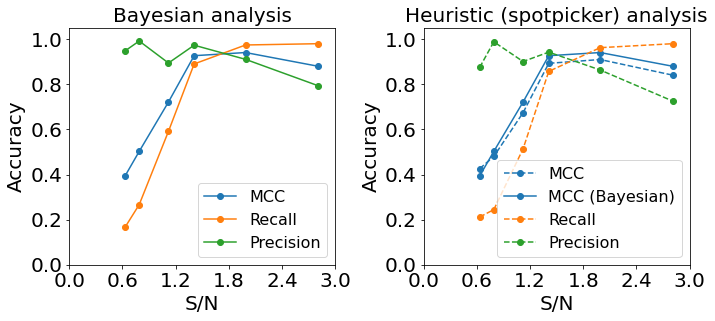

In [11]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")

plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel("S/N", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.6)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel("S/N", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.title("Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.6)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6607: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/ordabayev/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6608: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

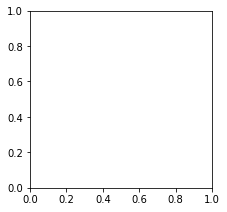

In [12]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[name]["z_prob"].ravel(), bins=100, alpha=0.7)
    plt.xlim(0, 1)
    #plt.ylim(0, 10)
    plt.yscale('log', nonposy='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"counts", fontsize=20)
    plt.title(r"S/N = {}".format(snr[i]), fontsize=20)

plt.tight_layout()
plt.show()

In [56]:
pyro.clear_param_store()
pyro.get_param_store().load(
    filename=os.path.join("experimental_data/FL_1_1117_0OD/runs/trackerv1.0/nojit/lr0.005/Adam/32", "params"),
    map_location=torch.device("cpu"))

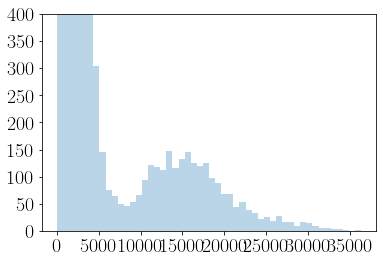

In [60]:
#mask = (predictions["FL_1_1117_0OD"]["m_prob"] > 0.2) & (predictions["FL_1_1117_0OD"]["m_prob"] < 0.8)
#mask = predictions["FL_1_1117_0OD"]["m_prob"] > 0.8
#mask = predictions["FL_1_1117_0OD"]["m"]
mask = np.transpose(mask, (2, 0, 1))
m_prob = np.transpose(predictions["FL_1_1117_0OD"]["m_prob"], (2, 0, 1))
z_prob = predictions["FL_1_1117_0OD"]["z_prob"]
#plt.hist(pyro.param("d/h_loc").data.numpy()[mask], bins=50, alpha=0.3)
plt.hist((pyro.param("d/h_loc").data.numpy()*m_prob).reshape(-1), bins=50, alpha=0.3)
#plt.hist((pyro.param("d/h_loc").data.numpy()*z_prob).reshape(-1), bins=50, alpha=0.3)
#plt.xlim(0., 5000)
plt.ylim(0, 400)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [25]:
bayes_mcc = [0.8349, 0.9303, 0.9336, 0.7625, 0.5713, 0.449]
sp_mcc = [0.9011, 0.9408, 0.9613, 0.8414, 0.6655, 0.5787]
sp_nohysteresis_mcc = [0.9164, 0.929, 0.8283, 0.6255, 0.4884, 0.3745]
sp_nohysteresis_0p5_mcc = [0.8459, 0.897, 0.879, 0.664, 0.4725, 0.4086]

tensor([[ 10.,  10.,  10.,  ...,  10.,  10.,  10.],
        [ 10.,  10.,  10.,  ...,  10.,  10.,  10.],
        [ 10.,  10.,  10.,  ...,  10.,  10.,  10.],
        ...,
        [103., 102., 101.,  ...,  84.,  83.,  82.],
        [104., 103., 102.,  ...,  85.,  84.,  83.],
        [105., 104., 103.,  ...,  86.,  85.,  84.]])
tensor([[  -5.2557,   -5.2557,   -5.2557,  ...,   -5.2557,   -5.2557,
           -5.2557],
        [  -5.2557,   -5.2557,   -5.2557,  ...,   -5.2557,   -5.2557,
           -5.2557],
        [  -5.2557,   -5.2557,   -5.2557,  ...,   -5.2557,   -5.2557,
           -5.2557],
        ...,
        [-123.7950, -122.4438, -121.0930,  ...,  -98.2146,  -96.8745,
          -95.5351],
        [-125.1467, -123.7950, -122.4438,  ...,  -99.5554,  -98.2146,
          -96.8745],
        [-126.4989, -125.1467, -123.7950,  ..., -100.8969,  -99.5554,
          -98.2146]])


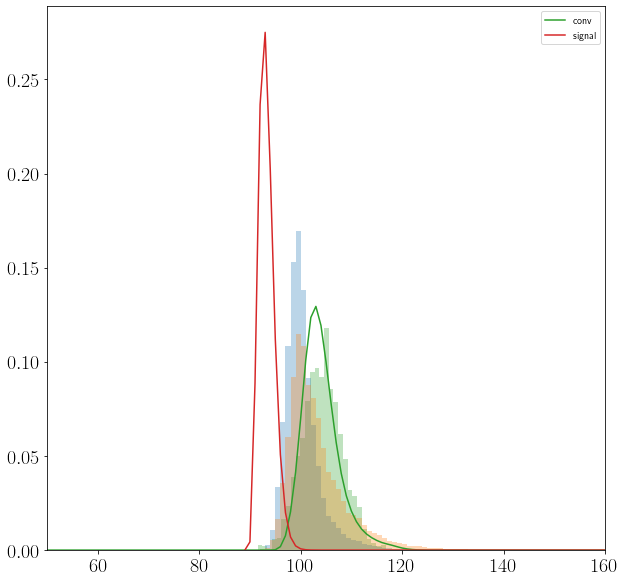

In [572]:
value = torch.arange(0, 200., 1)
cg = ConvGamma(torch.ones(200)*6., 1.4, offset_samples, offset_log_weights)
result = cg.log_prob(value).exp()

plt.figure(figsize=(10,10))

mu, var = data.offset.mean(), data.offset.var()
d1 = dist.Gamma(mu**2/var, mu/var)
d2 = dist.Gamma(6., 1.4)
d3 = dist.Gamma(6./1.4*1.88, 1.88)
plt.hist(d1.sample(torch.tensor([1500]))+d2.sample(torch.tensor([1500])), bins=30, density=True, alpha=0.3, color="C2")
plt.hist(data.offset.reshape(-1), bins=70, range=(80,150), density=True, alpha=0.3)
plt.hist(data.data.reshape(-1), bins=70, range=(80,150), density=True, alpha=0.3)

plt.plot(value, result, label="conv")
#plt.plot(value, d1.log_prob(value).exp(), label="offset")
plt.plot(value+89, d3.log_prob(value).exp(), label="signal")
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlim(50, 160)
plt.legend()
plt.show()

In [435]:
value = torch.ones(17,14,14)*150
cg = ConvGamma(torch.ones(2,17,14,14)*10., 0.2, offset_samples, offset_log_weights).to_event(2)
cg.log_prob(value).shape
#cg.event_shape

torch.Size([2, 17])

In [320]:
dc = dist.Gamma(torch.ones(190,22)*10., 0.2).mask(value.unsqueeze(dim=-1) > offset_samples).to_event(1)
#dc = dist.Gamma(torch.ones(190,22)*10., 0.2).to_event(1)
obs_logits = dc.log_prob(value.unsqueeze(dim=-1) - offset_samples)
obs_logits.shape

torch.Size([190])

In [333]:
value = torch.arange(115, 200., 0.5)
dc = dist.Gamma(torch.ones(190,22)*10., 0.2).mask(value.unsqueeze(dim=-1) > offset_samples)
#dc = dist.Gamma(torch.ones(190,22)*10., 0.2)
obs_logits = dc.log_prob(value.unsqueeze(dim=-1) - offset_samples)
result = obs_logits + offset_log_weights
result = torch.logsumexp(result, -1).exp()

ValueError: shape mismatch: objects cannot be broadcast to a single shape: torch.Size([1, 170, 22]) vs torch.Size([190, 22])

In [305]:
value.unsqueeze(dim=-1) - offset_samples

tensor([[ 11.0000,  10.0000,   9.0000,  ...,  -8.0000,  -9.0000, -10.0000],
        [ 11.5000,  10.5000,   9.5000,  ...,  -7.5000,  -8.5000,  -9.5000],
        [ 12.0000,  11.0000,  10.0000,  ...,  -7.0000,  -8.0000,  -9.0000],
        ...,
        [104.5000, 103.5000, 102.5000,  ...,  85.5000,  84.5000,  83.5000],
        [105.0000, 104.0000, 103.0000,  ...,  86.0000,  85.0000,  84.0000],
        [105.5000, 104.5000, 103.5000,  ...,  86.5000,  85.5000,  84.5000]])

In [306]:
obs_logits

tensor([[ -9.5151, -10.1729, -10.9212,  ...,      nan,      nan,      nan],
        [ -9.2151,  -9.8338, -10.5346,  ...,      nan,      nan,      nan],
        [ -8.9320,  -9.5151, -10.1729,  ...,      nan,      nan,      nan],
        ...,
        [ -7.9535,  -7.8401,  -7.7274,  ...,  -5.9596,  -5.8654,  -5.7726],
        [ -8.0106,  -7.8967,  -7.7836,  ...,  -6.0071,  -5.9123,  -5.8189],
        [ -8.0678,  -7.9535,  -7.8401,  ...,  -6.0549,  -5.9596,  -5.8654]])

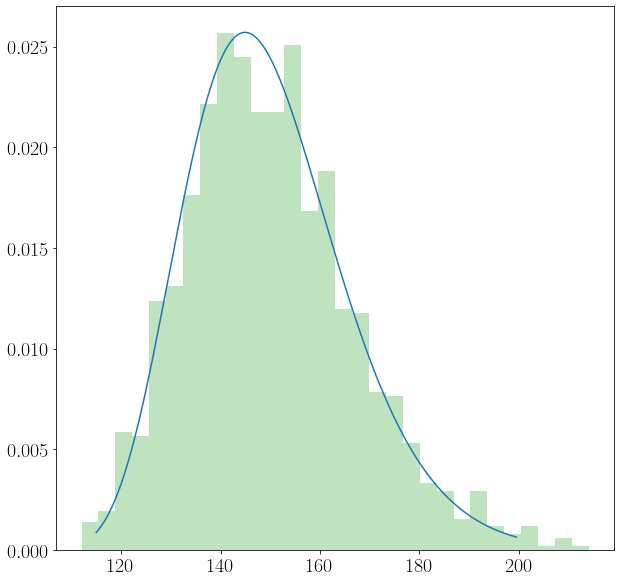

In [307]:
plt.figure(figsize=(10,10))

mu, var = data.offset.mean(), data.offset.var()
d1 = dist.Gamma(mu**2/var, mu/var)
d2 = dist.Gamma(10., 0.2)
plt.hist(d1.sample(torch.tensor([1500]))+d2.sample(torch.tensor([1500])), bins=30, density=True, alpha=0.3, color="C2")

#x = torch.arange(80, 160., 0.1)
#mu, var = data.offset.median(), data.offset.var()
#d = dist.Gamma(mu**2/var, mu/var)
#dn = dist.Normal(mu, torch.sqrt(var))
#plt.plot(x, torch.exp(d.log_prob(x)).cpu(), lw=5)
#plt.plot(x, torch.exp(dn.log_prob(x)).cpu(), lw=5)
#plt.hist(data.offset.reshape(-1), bins=500, density=True, alpha=0.3, color="C0")
#plt.xlim(70, 160)
plt.plot(value, result)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [247]:
offset_log_weights.shape

torch.Size([22])

In [ ]:
class Distribution(TorchDistribution):
    arg_constraints = {}  # nothing to be constrained

    def __init__(self, dist, emission_logits):
        self.dist = dist
        self.emission_logits = emission_logits
        batch_shape = emission_logits.shape[:-1]
        event_shape = self.dist.event_shape
        super().__init__(batch_shape, event_shape)

    def log_prob(self, value):
        #value = value.unsqueeze(-1 - self.dist.event_dim)
        obs_logits = dist.Gamma(10., 0.2).log_prob(value - offset_samples)
        result = obs_logits.unsqueeze(dim=-2) + offset_weights.log()
        result = torch.logsumexp(result, -1)
        return result

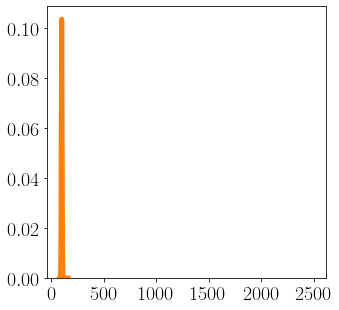

In [115]:
plt.figure(figsize=(5,5))
plt.hist(data.offset.reshape(-1), bins=100, density=True, alpha=0.3)

x = torch.arange(80, 160., 0.1)
mu, var = data.offset.median(), data.offset.var()
d = dist.Gamma(mu**2/var, mu/var)
plt.plot(x, torch.exp(d.log_prob(x)).cpu(), lw=5)
#plt.xlim(70, 500)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [116]:
mu, var

(tensor(99.), tensor(14.8781))

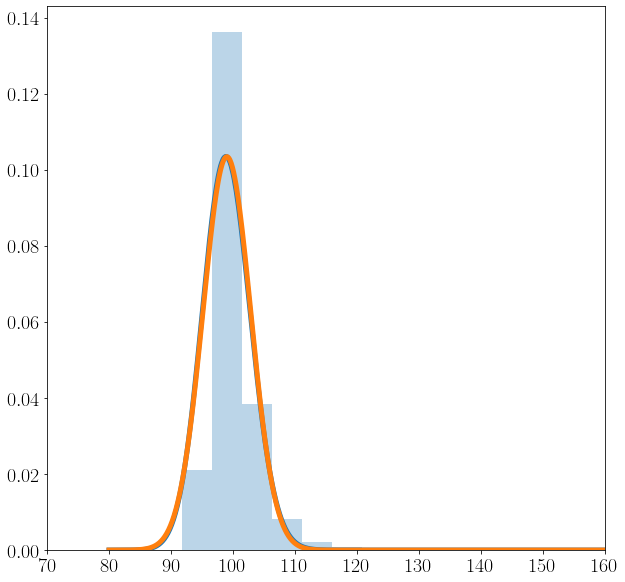

In [151]:
plt.figure(figsize=(10,10))

x = torch.arange(80, 160., 0.1)
mu, var = data.offset.median(), data.offset.var()
d = dist.Gamma(mu**2/var, mu/var)
dn = dist.Normal(mu, torch.sqrt(var))
plt.plot(x, torch.exp(d.log_prob(x)).cpu(), lw=5)
plt.plot(x, torch.exp(dn.log_prob(x)).cpu(), lw=5)
plt.hist(data.offset.reshape(-1), bins=500, density=True, alpha=0.3, color="C0")
plt.xlim(70, 160)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

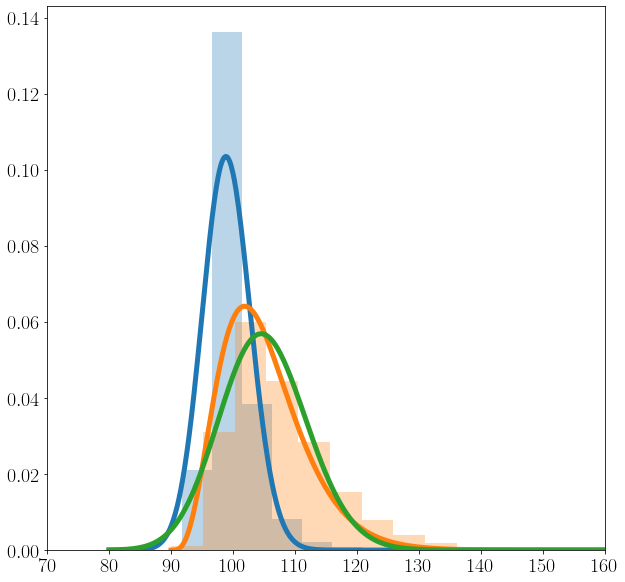

In [122]:
plt.figure(figsize=(10,10))

x = torch.arange(80, 160., 0.1)
mu, var = data.offset.median(), data.offset.var()
d = dist.Gamma(mu**2/var, mu/var)
dfl = dist.Gamma(15 / 3.12, 1/3.12)
dfi = dist.Gamma((6+mu)**2/(6*5.75+var), (6+mu)/(6*5.75+var))
plt.plot(x, torch.exp(d.log_prob(x)).cpu(), lw=5)
plt.plot(x, torch.exp(dfl.log_prob(x-90)).cpu(), lw=5)
plt.plot(x, torch.exp(dfi.log_prob(x)).cpu(), lw=5)
plt.hist(data.offset.reshape(-1), bins=500, density=True, alpha=0.3, color="C0")
plt.hist(data.data.reshape(-1), bins=500, density=True, alpha=0.3, color="C1")
plt.xlim(70, 160)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [136]:
om = - (var+6*5.75)**2 / (var**2/mu + 6*5.75**2) + mu + 6
om

tensor(92.8461)

In [138]:
g = (var+6*5.75) / (6 + mu - om)
g

tensor(4.0628)

In [140]:
loc = mu + 6 - om
loc

tensor(12.1539)

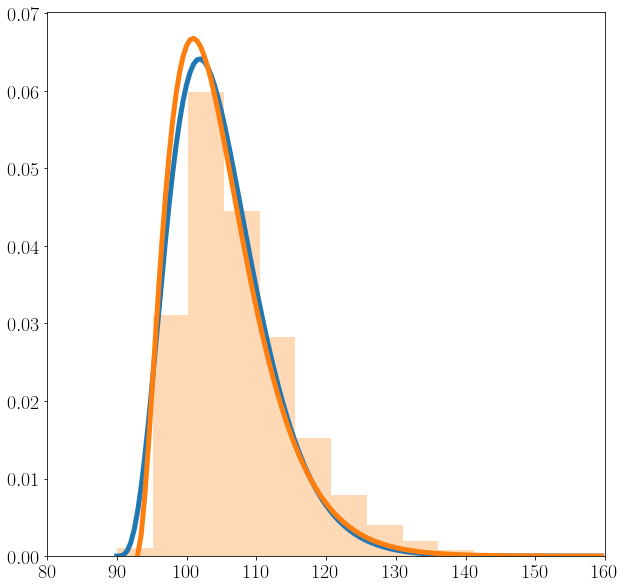

In [149]:
plt.figure(figsize=(10,10))

x = torch.arange(80, 160., 0.5)
mu, var = data.offset.median(), data.offset.var()
d1 = dist.Gamma(mu**2/var, mu/var)
d2 = dist.Gamma(6 / 5.75, 1/5.75)
dfi = dist.Gamma((6+mu)**2/(6*5.75+var), (6+mu)/(6*5.75+var))
dfl = dist.Gamma(15 / 3.12, 1/3.12)
dm = dist.Gamma(loc/ g, 1/g)
#plt.plot(x, torch.exp(d1.log_prob(x)).cpu(), lw=5)
#plt.plot(x, torch.exp(d2.log_prob(x)).cpu(), lw=5)
#plt.plot(x, torch.exp(dfi.log_prob(x)).cpu(), lw=5)
#plt.hist(d1.sample(torch.tensor([500])), bins=20, density=True, alpha=0.3, color="C0")
#plt.hist(d2.sample(torch.tensor([500])), bins=20, density=True, alpha=0.3, color="C1")
#plt.hist(d1.sample(torch.tensor([1500]))+d2.sample(torch.tensor([1500])), bins=30, density=True, alpha=0.3, color="C2")
plt.hist(data.data.reshape(-1), bins=500, density=True, alpha=0.3, color="C1")
plt.plot(x, torch.exp(dfl.log_prob(x-90)).cpu(), lw=5)
plt.plot(x, torch.exp(dm.log_prob(x-om)).cpu(), lw=5)
plt.xlim(80, 160)
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

In [425]:
pyro.clear_param_store()
pyro.get_param_store().load(
    filename=os.path.join("experimental_data/FL_1118_2225_0p3OD/runs/featurev0.9.8/nojit/lr0.005/Adam/32", "params"),
    map_location=torch.device("cpu"))

In [637]:
results = {}
predictions = {}
hs = ["h1000", "h1500", "h2000", "-2-g4f08789"]


for h in hs:
    results[h] = pd.read_csv("experimental_data/FL_3339_4444_0p8OD/runs/marginalv0.9.9{}/nojit/lr0.005/Adam/32/params_last.csv".format(h),
                            header=None, squeeze=True, index_col=0)
    predictions[h] = np.load(
        "experimental_data/FL_3339_4444_0p8OD/runs/marginalv0.9.9{}/nojit/lr0.005/Adam/32/predictions.npy".format(h))

In [638]:
for h in hs:
    print(h)
    print(results[h]["MCC"])
    print(results[h]["FP"])
    print(results[h]["FN"])
    print("")

h1000
0.5877620057069463
1289.0
12.0

h1500
0.7541964804275003
499.0
23.0

h2000
0.8967707663610587
123.0
41.0

-2-g4f08789
0.833230781742093
271.0
30.0



In [659]:
results = {}
predictions = {}
hs = ["h1000", "h2000", "h2500"]


for h in hs:
    results[h] = pd.read_csv("experimental_data/FL_3339_4444_0p8OD/runs/marginalv0.9.9-3-ge7eadea{}/nojit/lr0.005/Adam/32/params_last.csv".format(h),
                            header=None, squeeze=True, index_col=0)
    predictions[h] = np.load(
        "experimental_data/FL_3339_4444_0p8OD/runs/marginalv0.9.9-3-ge7eadea{}/nojit/lr0.005/Adam/32/predictions.npy".format(h))

In [660]:
for h in hs:
    print(h)
    print(results[h]["MCC"])
    print(results[h]["FP"])
    print(results[h]["FN"])
    print("")

h1000
0.8161193586794108
301.0
36.0

h2000
0.8509395734967966
215.0
40.0

h2500
0.8471353169023704
228.0
37.0



In [ ]:
v0.9.6
h500
0.71
641
25

h1000
0.8166
320
25

h2000
0.891
131
43

In [85]:
results = {}
predictions = {}
hs = ["1000", "1500", "2000"]


for h in hs:
    results[h] = pd.read_csv("test_data/GraceArticlePol2/runs/marginalv0.9.9h{}/nojit/lr0.005/Adam/32/params_last.csv".format(h),
                            header=None, squeeze=True, index_col=0)
    predictions[h] = np.load(
        "test_data/GraceArticlePol2/runs/marginalv0.9.9h{}/nojit/lr0.005/Adam/32/predictions.npy".format(h))

In [88]:
for h in hs:
    print(h)
    print("MCC", results[h]["MCC"])
    print("FP", results[h]["FP"])
    print("FN", results[h]["FN"])
    print("")

1000
MCC 0.8294362828373321
FP 4719.0
FN 5662.0

1500
MCC 0.828344171964331
FP 3289.0
FN 6899.0

2000
MCC 0.7996639785064928
FP 2041.0
FN 9558.0



In [632]:
for h in hs:
    print(h)
    print(results[h]["MCC"])
    print(results[h]["FP"])
    print(results[h]["FN"])
    print("")

1000
0.8294362828373321
4719.0
5662.0

1500
0.828344171964331
3289.0
6899.0

2000
0.7996639785064928
2041.0
9558.0



In [79]:
from cosmos.utils.glimpse_reader import load_data

In [81]:
load_data(path="height_data/h0300pi15lamda15/", dtype="test", device=torch.device("cpu"))

CoSMoSDataset
N=15, F=500, D=14
dtype='test'

In [76]:
data, control = ReadAoi(path="height_data/h0300pi15lamda15/",
                  control="control", device=torch.device("cpu"))

dir: 
header: 
aoiinfo: 
driftlist: 
labels: 


FileNotFoundError: [Errno 2] No such file or directory: '.mat'